# 📊 Projeto de Automação e Análise de Dados de Contratos e Convênios

**Autor:** Artenio Reis  
**Disciplina:** Análise e Automação de Dados  
**Objetivo:** Demonstrar um processo completo de:
- Leitura de dados de contratos e convênios
- Tratamento e padronização das informações
- Criação de banco de dados (SQL Server)
- Análise com métricas e gráficos relevantes
- Exportação de relatório
- Envio automático por e-mail diariamente

---

## 1. IMPORTANDO BIBLIOTECAS NECESSÁRIAS

In [1]:
# -*- coding: utf-8 -*-
"""
Projeto de Automação e Análise de Dados - Ceará Transparente
Automação para extração e análise de dados de contratos e convênios
"""


import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json
import warnings
import time
from sqlalchemy import create_engine
import sqlite3

# Configurações de visualização
plt.style.use('default')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

## 2. PARÂMETROS E CONFIGURAÇÕES

In [2]:

# URLs das APIs base (sem parâmetros de paginação)
BASE_URL_CONVENIOS = 'https://api-dados-abertos.cearatransparente.ce.gov.br/transparencia/contratos/convenios'
BASE_URL_CONTRATOS = 'https://api-dados-abertos.cearatransparente.ce.gov.br/transparencia/contratos/contratos'

# Parâmetros de data para filtro
params = {
    'data_assinatura_inicio': '01/01/2024',
    'data_assinatura_fim': '31/12/2024'
}

## 3. FUNÇÕES PARA COLETA DE DADOS

In [3]:


def fazer_requisicao_api(url, params=None):
    """
    Faz requisição para a API e retorna os dados
    
    Parameters:
    url (str): URL da API
    params (dict): Parâmetros da requisição
    
    Returns:
    dict: Dados da resposta da API
    """
    try:
        response = requests.get(url, params=params, timeout=30)
        response.raise_for_status()  # Levanta exceção para erros HTTP
        
        print(f"✅ Requisição bem-sucedida para: {url}")
        return response.json()
    
    except requests.exceptions.RequestException as e:
        print(f"❌ Erro na requisição: {e}")
        return None

def extrair_todas_paginas(url_base, params, max_paginas=10):
    """
    Extrai dados de todas as páginas disponíveis na API
    
    Parameters:
    url_base (str): URL base da API
    params (dict): Parâmetros da requisição
    max_paginas (int): Número máximo de páginas a extrair
    
    Returns:
    list: Lista com todos os registros
    """
    todos_dados = []
    
    for pagina in range(1, max_paginas + 1):
        print(f"📄 Extraindo página {pagina}...")
        
        # Adiciona parâmetro de página
        params_pagina = params.copy()
        params_pagina['page'] = pagina
        
        dados = fazer_requisicao_api(url_base, params_pagina)
        
        if dados and 'data' in dados and dados['data']:
            todos_dados.extend(dados['data'])
            print(f"   ✅ {len(dados['data'])} registros extraídos")
            
            # Verifica se há mais páginas
            if len(dados['data']) < 15:  # Supondo 15 registros por página
                print("🏁 Última página alcançada")
                break
                
            # Pequena pausa para não sobrecarregar a API
            time.sleep(0.5)
        else:
            print("🚫 Nenhum dado encontrado ou fim dos dados")
            break
    
    print(f"🎯 Total de registros extraídos: {len(todos_dados)}")
    return todos_dados


## 4. EXTRAÇÃO DE DADOS - CONVÊNIOS

In [4]:



print("=" * 60)
print("🚀 INICIANDO EXTRAÇÃO DE DADOS - CONVÊNIOS")
print("=" * 60)

# Extraindo dados de convênios
dados_convenios = extrair_todas_paginas(BASE_URL_CONVENIOS, params, max_paginas=5)

# Convertendo para DataFrame
if dados_convenios:
    df_convenios = pd.DataFrame(dados_convenios)
    print(f"📊 DataFrame Convênios criado: {df_convenios.shape}")
else:
    df_convenios = pd.DataFrame()
    print("⚠️  Nenhum dado de convênios extraído")



🚀 INICIANDO EXTRAÇÃO DE DADOS - CONVÊNIOS
📄 Extraindo página 1...


✅ Requisição bem-sucedida para: https://api-dados-abertos.cearatransparente.ce.gov.br/transparencia/contratos/convenios
   ✅ 25 registros extraídos


📄 Extraindo página 2...


✅ Requisição bem-sucedida para: https://api-dados-abertos.cearatransparente.ce.gov.br/transparencia/contratos/convenios
   ✅ 25 registros extraídos


📄 Extraindo página 3...


✅ Requisição bem-sucedida para: https://api-dados-abertos.cearatransparente.ce.gov.br/transparencia/contratos/convenios
   ✅ 25 registros extraídos


📄 Extraindo página 4...


✅ Requisição bem-sucedida para: https://api-dados-abertos.cearatransparente.ce.gov.br/transparencia/contratos/convenios
   ✅ 25 registros extraídos


📄 Extraindo página 5...


✅ Requisição bem-sucedida para: https://api-dados-abertos.cearatransparente.ce.gov.br/transparencia/contratos/convenios
   ✅ 25 registros extraídos


🎯 Total de registros extraídos: 125
📊 DataFrame Convênios criado: (125, 65)


## 5. EXTRAÇÃO DE DADOS - CONTRATOS

In [5]:

print("\n" + "=" * 60)
print("🚀 INICIANDO EXTRAÇÃO DE DADOS - CONTRATOS")
print("=" * 60)

# Extraindo dados de contratos
dados_contratos = extrair_todas_paginas(BASE_URL_CONTRATOS, params, max_paginas=5)

# Convertendo para DataFrame
if dados_contratos:
    df_contratos = pd.DataFrame(dados_contratos)
    print(f"📊 DataFrame Contratos criado: {df_contratos.shape}")
else:
    df_contratos = pd.DataFrame()
    print("⚠️  Nenhum dado de contratos extraído")


🚀 INICIANDO EXTRAÇÃO DE DADOS - CONTRATOS
📄 Extraindo página 1...


✅ Requisição bem-sucedida para: https://api-dados-abertos.cearatransparente.ce.gov.br/transparencia/contratos/contratos
   ✅ 100 registros extraídos


📄 Extraindo página 2...


✅ Requisição bem-sucedida para: https://api-dados-abertos.cearatransparente.ce.gov.br/transparencia/contratos/contratos
   ✅ 100 registros extraídos


📄 Extraindo página 3...


✅ Requisição bem-sucedida para: https://api-dados-abertos.cearatransparente.ce.gov.br/transparencia/contratos/contratos
   ✅ 100 registros extraídos


📄 Extraindo página 4...


✅ Requisição bem-sucedida para: https://api-dados-abertos.cearatransparente.ce.gov.br/transparencia/contratos/contratos
   ✅ 100 registros extraídos


📄 Extraindo página 5...


✅ Requisição bem-sucedida para: https://api-dados-abertos.cearatransparente.ce.gov.br/transparencia/contratos/contratos
   ✅ 100 registros extraídos


🎯 Total de registros extraídos: 500
📊 DataFrame Contratos criado: (500, 65)


## 6. EXPLORAÇÃO INICIAL DOS DADOS

In [6]:



print("\n" + "=" * 60)
print("🔍 EXPLORAÇÃO INICIAL DOS DADOS")
print("=" * 60)

# Função para explorar dados
def explorar_dataframe(df, nome):
    """
    Função para explorar um DataFrame
    """
    print(f"\n📋 EXPLORAÇÃO: {nome}")
    print("-" * 40)
    
    if df.empty:
        print("DataFrame vazio")
        return
    
    print(f"📐 Dimensões: {df.shape}")
    print(f"📝 Colunas: {list(df.columns)}")
    print("\n📊 Informações básicas:")
    print(df.info())
    
    print("\n🔢 Estatísticas descritivas:")
    print(df.describe())
    
    print("\n🔍 Primeiras linhas:")
    print(df.head(3))

# Explorando os DataFrames
explorar_dataframe(df_convenios, "CONVÊNIOS")
explorar_dataframe(df_contratos, "CONTRATOS")


🔍 EXPLORAÇÃO INICIAL DOS DADOS

📋 EXPLORAÇÃO: CONVÊNIOS
----------------------------------------
📐 Dimensões: (125, 65)
📝 Colunas: ['id', 'cod_concedente', 'cod_financiador', 'cod_gestora', 'cod_orgao', 'cod_secretaria', 'descricao_modalidade', 'descricao_objeto', 'descricao_tipo', 'descricao_url', 'data_assinatura', 'data_processamento', 'data_termino', 'flg_tipo', 'isn_parte_destino', 'isn_sic', 'num_spu', 'valor_contrato', 'isn_modalidade', 'isn_entidade', 'tipo_objeto', 'num_spu_licitacao', 'descricao_justificativa', 'valor_can_rstpg', 'data_publicacao_portal', 'descricao_url_pltrb', 'descricao_url_ddisp', 'descricao_url_inexg', 'cod_plano_trabalho', 'num_certidao', 'descriaco_edital', 'cpf_cnpj_financiador', 'num_contrato', 'valor_original_concedente', 'valor_original_contrapartida', 'valor_atualizado_concedente', 'valor_atualizado_contrapartida', 'created_at', 'updated_at', 'plain_num_contrato', 'calculated_valor_aditivo', 'calculated_valor_ajuste', 'calculated_valor_empenhado',

## 7. PRÉ-PROCESSAMENTO E LIMPEZA DE DADOS

In [7]:

print("\n" + "=" * 60)
print("🧹 PRÉ-PROCESSAMENTO E LIMPEZA DE DADOS")
print("=" * 60)

def preprocessar_dados(df, tipo):
    """
    Função para pré-processar os dados
    
    Parameters:
    df (DataFrame): DataFrame a ser processado
    tipo (str): Tipo de dados ('convenios' ou 'contratos')
    
    Returns:
    DataFrame: DataFrame processado
    """
    if df.empty:
        return df
    
    df_clean = df.copy()
    
    # Convertendo colunas de data
    colunas_data = ['data_assinatura', 'data_processamento', 'data_termino']
    for coluna in colunas_data:
        if coluna in df_clean.columns:
            df_clean[coluna] = pd.to_datetime(df_clean[coluna], errors='coerce')
    
    # Convertendo colunas numéricas
    colunas_valores = ['valor_contrato', 'valor_aditivo', 'valor_empenhado', 
                      'valor_ajuste', 'valor_pago', 'valor_original_concedente',
                      'valor_original_contrapartida']
    
    for coluna in colunas_valores:
        if coluna in df_clean.columns:
            df_clean[coluna] = pd.to_numeric(df_clean[coluna], errors='coerce')
    
    print(f"✅ Dados {tipo} pré-processados")
    return df_clean

# Aplicando pré-processamento
df_convenios_clean = preprocessar_dados(df_convenios, 'convênios')
df_contratos_clean = preprocessar_dados(df_contratos, 'contratos')


🧹 PRÉ-PROCESSAMENTO E LIMPEZA DE DADOS
✅ Dados convênios pré-processados
✅ Dados contratos pré-processados


## 8. ANÁLISE EXPLORATÓRIA DE DADOS (AED)


📊 ANÁLISE EXPLORATÓRIA DE DADOS (AED)
🔍 VERIFICANDO COLUNAS DISPONÍVEIS...

🔍 COLUNAS DISPONÍVEIS EM CONVÊNIOS:
----------------------------------------
   • id
   • cod_concedente
   • cod_financiador
   • cod_gestora
   • cod_orgao
   • cod_secretaria
   • descricao_modalidade
   • descricao_objeto
   • descricao_tipo
   • descricao_url
   • data_assinatura
   • data_processamento
   • data_termino
   • flg_tipo
   • isn_parte_destino
   • isn_sic
   • num_spu
   • valor_contrato
   • isn_modalidade
   • isn_entidade
   • tipo_objeto
   • num_spu_licitacao
   • descricao_justificativa
   • valor_can_rstpg
   • data_publicacao_portal
   • descricao_url_pltrb
   • descricao_url_ddisp
   • descricao_url_inexg
   • cod_plano_trabalho
   • num_certidao
   • descriaco_edital
   • cpf_cnpj_financiador
   • num_contrato
   • valor_original_concedente
   • valor_original_contrapartida
   • valor_atualizado_concedente
   • valor_atualizado_contrapartida
   • created_at
   • updated_at
   • pl

💾 Gráfico salvo: graf_analise_convênios.png


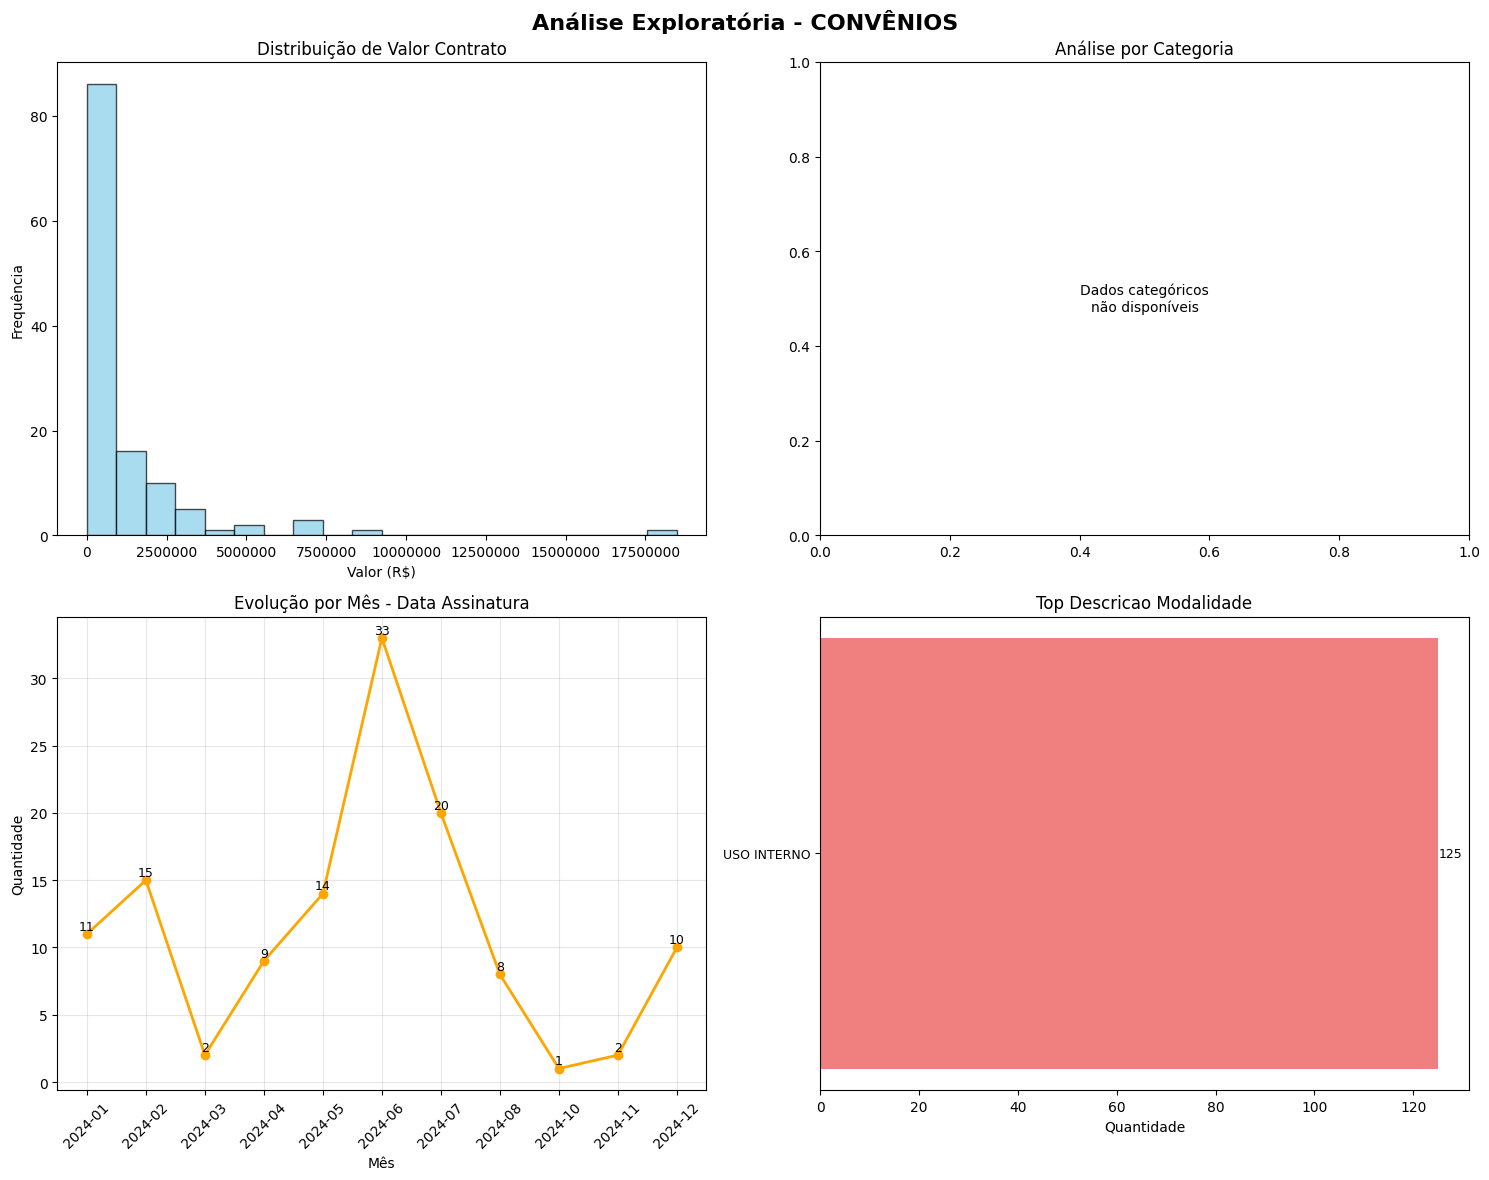


📈 ESTATÍSTICAS PARA CONVÊNIOS:
----------------------------------------
🔢 Total de registros: 125
📊 Total de colunas: 65
💰 Valor total: R$ 137,057,244.40
📊 Valor médio: R$ 1,096,457.96
🎯 Valor máximo: R$ 18,483,853.97
📉 Valor mínimo: R$ 4,000.00

📈 Gerando gráficos de contratos...

🔍 COLUNAS DISPONÍVEIS EM CONTRATOS:
----------------------------------------
   • id
   • cod_concedente
   • cod_financiador
   • cod_gestora
   • cod_orgao
   • cod_secretaria
   • descricao_modalidade
   • descricao_objeto
   • descricao_tipo
   • descricao_url
   • data_assinatura
   • data_processamento
   • data_termino
   • flg_tipo
   • isn_parte_destino
   • isn_sic
   • num_spu
   • valor_contrato
   • isn_modalidade
   • isn_entidade
   • tipo_objeto
   • num_spu_licitacao
   • descricao_justificativa
   • valor_can_rstpg
   • data_publicacao_portal
   • descricao_url_pltrb
   • descricao_url_ddisp
   • descricao_url_inexg
   • cod_plano_trabalho
   • num_certidao
   • descriaco_edital
   • cpf_c

💾 Gráfico salvo: graf_analise_contratos.png


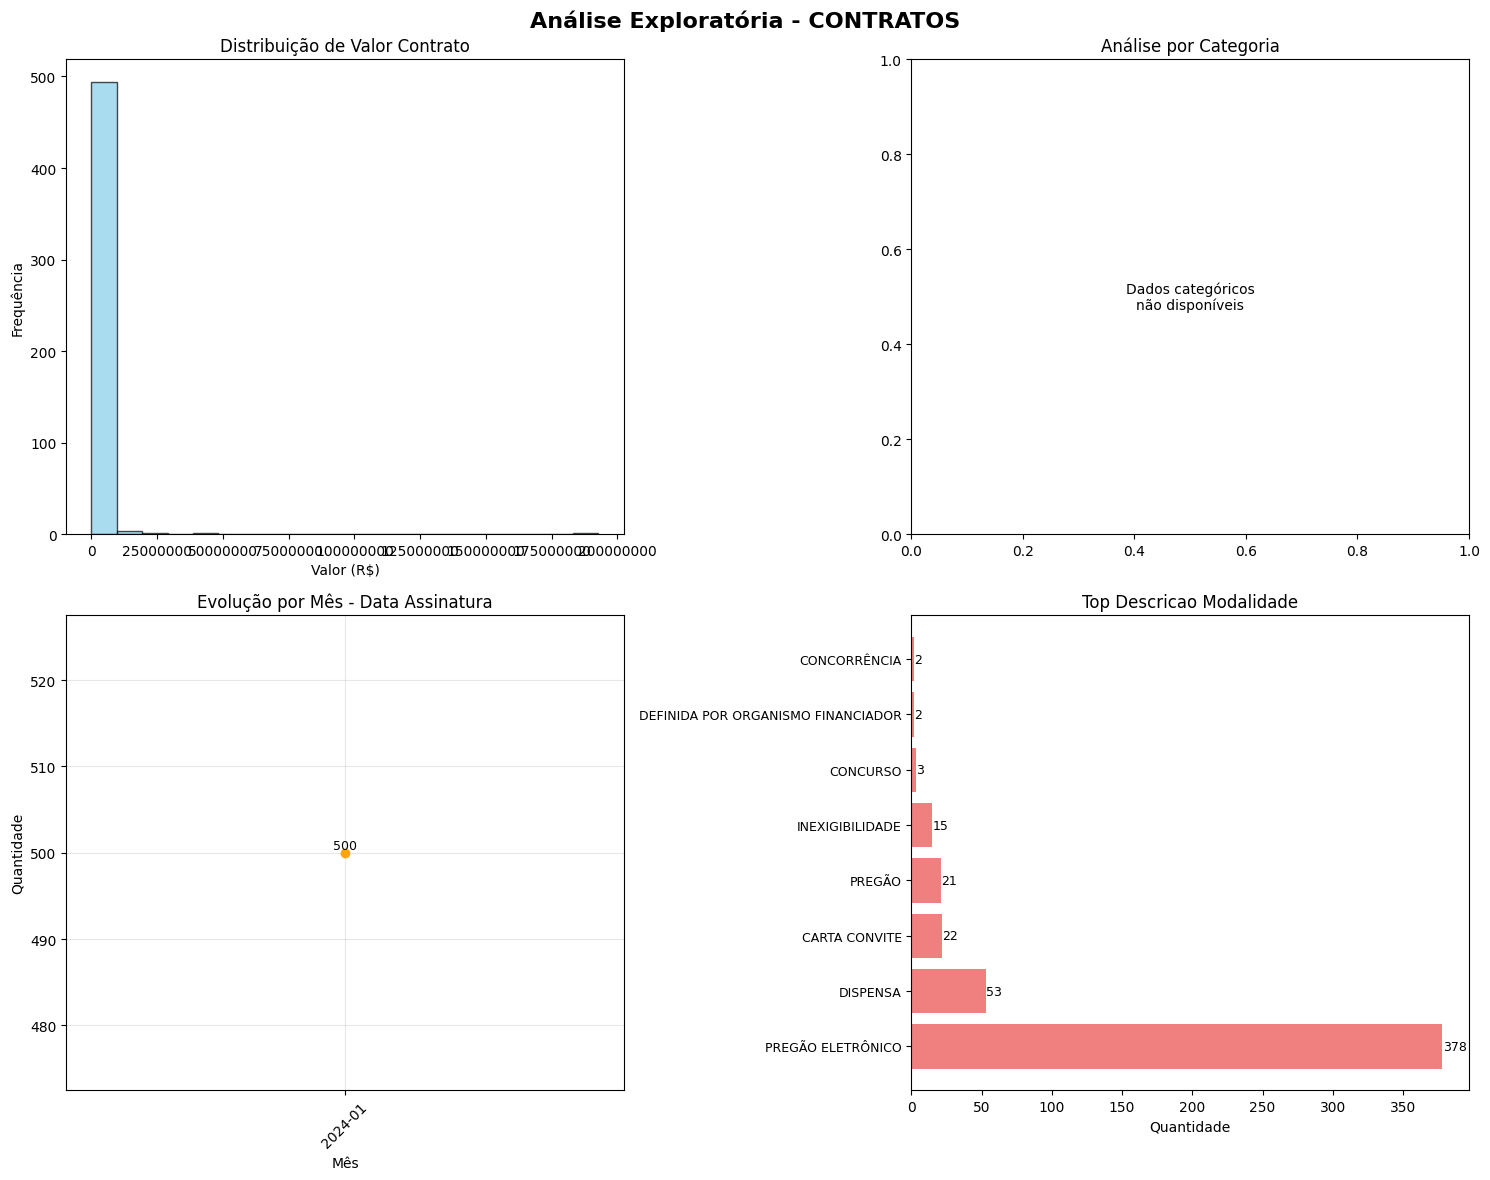


📈 ESTATÍSTICAS PARA CONTRATOS:
----------------------------------------
🔢 Total de registros: 500
📊 Total de colunas: 65
💰 Valor total: R$ 377,586,616.59
📊 Valor médio: R$ 755,173.23
🎯 Valor máximo: R$ 192,819,485.29
📉 Valor mínimo: R$ 13.65

📊 Gerando gráficos comparativos...


💾 Gráfico salvo: graf_comparativo_valores.png


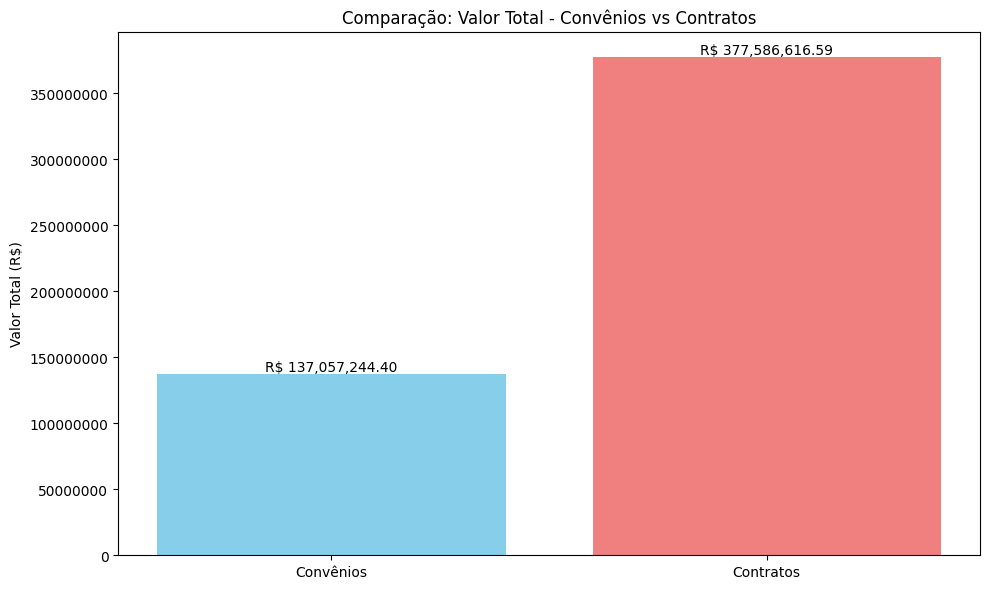

💾 Gráfico salvo: graf_comparativo_quantidade.png


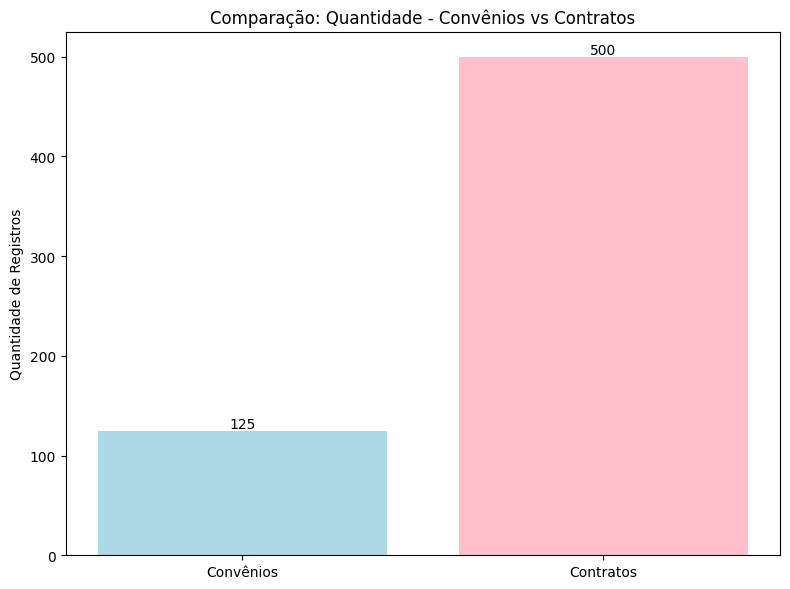

✅ Gráficos comparativos gerados: 2


In [8]:
print("\n" + "=" * 60)
print("📊 ANÁLISE EXPLORATÓRIA DE DADOS (AED)")
print("=" * 60)

def verificar_colunas_disponiveis(df, tipo):
    """
    Verifica quais colunas estão disponíveis no DataFrame
    """
    print(f"\n🔍 COLUNAS DISPONÍVEIS EM {tipo.upper()}:")
    print("-" * 40)
    for coluna in df.columns:
        print(f"   • {coluna}")
    
    # Colunas importantes que procuramos
    colunas_importantes = ['orgao', 'descricao_modalidade', 'data_assinatura', 'valor_contrato']
    colunas_encontradas = [col for col in colunas_importantes if col in df.columns]
    colunas_faltantes = [col for col in colunas_importantes if col not in df.columns]
    
    print(f"\n📋 Colunas importantes encontradas: {colunas_encontradas}")
    if colunas_faltantes:
        print(f"⚠️  Colunas importantes faltantes: {colunas_faltantes}")
    
    return colunas_encontradas

def criar_visualizacoes(df, tipo):
    """
    Cria visualizações para análise exploratória e salva os gráficos
    """
    if df.empty:
        print(f"⚠️  Nenhum dado disponível para {tipo}")
        return
    
    # Primeiro verificar colunas disponíveis
    colunas_disponiveis = verificar_colunas_disponiveis(df, tipo)
    
    # Configuração para múltiplos gráficos
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'Análise Exploratória - {tipo.upper()}', fontsize=16, fontweight='bold')
    
    gráficos_gerados = 0
    
    # 1. Distribuição de valores (se existir coluna de valor)
    colunas_valor = [col for col in df.columns if 'valor' in col.lower()]
    if colunas_valor:
        # Pegando a primeira coluna de valor disponível
        coluna_valor = colunas_valor[0]
        valores_validos = df[coluna_valor].dropna()
        
        if not valores_validos.empty:
            axes[0, 0].hist(valores_validos, bins=20, edgecolor='black', alpha=0.7, color='skyblue')
            axes[0, 0].set_title(f'Distribuição de {coluna_valor.replace("_", " ").title()}')
            axes[0, 0].set_xlabel('Valor (R$)')
            axes[0, 0].set_ylabel('Frequência')
            axes[0, 0].ticklabel_format(style='plain', axis='x')
            gráficos_gerados += 1
    else:
        axes[0, 0].text(0.5, 0.5, 'Dados de valor\nnão disponíveis', 
                       ha='center', va='center', transform=axes[0, 0].transAxes)
        axes[0, 0].set_title('Distribuição de Valores')
    
    # 2. Contagem por órgão ou outra coluna categórica
    colunas_categoricas = [col for col in ['orgao', 'concedente', 'gestora', 'financiador'] if col in df.columns]
    if colunas_categoricas:
        coluna_categoria = colunas_categoricas[0]  # Usa a primeira disponível
        top_categorias = df[coluna_categoria].value_counts().head(10)
        
        axes[0, 1].barh(range(len(top_categorias)), top_categorias.values, color='lightgreen')
        axes[0, 1].set_yticks(range(len(top_categorias)))
        axes[0, 1].set_yticklabels(top_categorias.index, fontsize=8)
        axes[0, 1].set_title(f'Top 10 {coluna_categoria.replace("_", " ").title()}')
        axes[0, 1].set_xlabel('Quantidade')
        
        # Adicionando valores nas barras
        for i, v in enumerate(top_categorias.values):
            axes[0, 1].text(v + 0.1, i, str(v), va='center', fontsize=9)
        gráficos_gerados += 1
    else:
        axes[0, 1].text(0.5, 0.5, 'Dados categóricos\nnão disponíveis', 
                       ha='center', va='center', transform=axes[0, 1].transAxes)
        axes[0, 1].set_title('Análise por Categoria')
    
    # 3. Evolução temporal por mês (se existir data)
    colunas_data = [col for col in df.columns if 'data' in col.lower()]
    if colunas_data:
        coluna_data = colunas_data[0]  # Usa a primeira coluna de data disponível
        try:
            df_temp = df.copy()
            df_temp['mes_analise'] = pd.to_datetime(df_temp[coluna_data]).dt.to_period('M')
            dados_por_mes = df_temp['mes_analise'].value_counts().sort_index()
            
            axes[1, 0].plot(range(len(dados_por_mes)), dados_por_mes.values, 
                           marker='o', linewidth=2, markersize=6, color='orange')
            axes[1, 0].set_title(f'Evolução por Mês - {coluna_data.replace("_", " ").title()}')
            axes[1, 0].set_xlabel('Mês')
            axes[1, 0].set_ylabel('Quantidade')
            axes[1, 0].set_xticks(range(len(dados_por_mes)))
            axes[1, 0].set_xticklabels([str(x) for x in dados_por_mes.index], rotation=45)
            axes[1, 0].grid(True, alpha=0.3)
            
            # Adicionando valores nos pontos
            for i, v in enumerate(dados_por_mes.values):
                axes[1, 0].text(i, v + 0.1, str(v), ha='center', va='bottom', fontsize=9)
            gráficos_gerados += 1
        except Exception as e:
            axes[1, 0].text(0.5, 0.5, f'Erro ao processar datas:\n{e}', 
                           ha='center', va='center', transform=axes[1, 0].transAxes)
            axes[1, 0].set_title('Evolução Temporal')
    else:
        axes[1, 0].text(0.5, 0.5, 'Dados de data\nnão disponíveis', 
                       ha='center', va='center', transform=axes[1, 0].transAxes)
        axes[1, 0].set_title('Evolução Temporal')
    
    # 4. Modalidade de licitação ou outra coluna categórica
    colunas_modalidade = [col for col in ['descricao_modalidade', 'descricao_tipo', 'tipo'] if col in df.columns]
    if colunas_modalidade:
        coluna_modalidade = colunas_modalidade[0]
        modalidades = df[coluna_modalidade].value_counts().head(8)
        
        # Gráfico de barras horizontais
        bars = axes[1, 1].barh(range(len(modalidades)), modalidades.values, color='lightcoral')
        axes[1, 1].set_yticks(range(len(modalidades)))
        axes[1, 1].set_yticklabels(modalidades.index, fontsize=9)
        axes[1, 1].set_title(f'Top {coluna_modalidade.replace("_", " ").title()}')
        axes[1, 1].set_xlabel('Quantidade')
        
        # Adicionando valores nas barras
        for i, v in enumerate(modalidades.values):
            axes[1, 1].text(v + 0.1, i, str(v), va='center', fontsize=9)
        gráficos_gerados += 1
    else:
        axes[1, 1].text(0.5, 0.5, 'Dados de modalidade/tipo\nnão disponíveis', 
                       ha='center', va='center', transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('Distribuição por Tipo')
    
    plt.tight_layout()
    
    # Salvar gráfico apenas se gerou algum gráfico válido
    if gráficos_gerados > 0:
        nome_arquivo = f"graf_analise_{tipo.lower()}.png"
        plt.savefig(nome_arquivo, dpi=300, bbox_inches='tight')
        print(f"💾 Gráfico salvo: {nome_arquivo}")
    else:
        print(f"⚠️  Nenhum gráfico válido gerado para {tipo}")
    
    plt.show()
    
    # Estatísticas adicionais
    print(f"\n📈 ESTATÍSTICAS PARA {tipo.upper()}:")
    print("-" * 40)
    print(f"🔢 Total de registros: {len(df)}")
    print(f"📊 Total de colunas: {len(df.columns)}")
    
    if colunas_valor:
        coluna_principal = colunas_valor[0]
        print(f"💰 Valor total: R$ {df[coluna_principal].sum():,.2f}")
        print(f"📊 Valor médio: R$ {df[coluna_principal].mean():,.2f}")
        print(f"🎯 Valor máximo: R$ {df[coluna_principal].max():,.2f}")
        print(f"📉 Valor mínimo: R$ {df[coluna_principal].min():,.2f}")

def criar_graficos_comparativos():
    """
    Cria gráficos comparativos entre convênios e contratos
    """
    if df_convenios_clean.empty or df_contratos_clean.empty:
        print("⚠️  Dados insuficientes para gráficos comparativos")
        return
    
    gráficos_gerados = 0
    
    # Gráfico 1: Comparação de valores totais
    coluna_valor_conv = next((col for col in df_convenios_clean.columns if 'valor' in col.lower()), None)
    coluna_valor_contr = next((col for col in df_contratos_clean.columns if 'valor' in col.lower()), None)
    
    if coluna_valor_conv and coluna_valor_contr:
        plt.figure(figsize=(10, 6))
        
        categorias = ['Convênios', 'Contratos']
        valores_totais = [
            df_convenios_clean[coluna_valor_conv].sum(),
            df_contratos_clean[coluna_valor_contr].sum()
        ]
        
        barras = plt.bar(categorias, valores_totais, color=['skyblue', 'lightcoral'])
        plt.title('Comparação: Valor Total - Convênios vs Contratos')
        plt.ylabel('Valor Total (R$)')
        plt.ticklabel_format(style='plain', axis='y')
        
        # Adicionando valores nas barras
        for barra, valor in zip(barras, valores_totais):
            altura = barra.get_height()
            plt.text(barra.get_x() + barra.get_width()/2., altura,
                    f'R$ {valor:,.2f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.savefig('graf_comparativo_valores.png', dpi=300, bbox_inches='tight')
        print("💾 Gráfico salvo: graf_comparativo_valores.png")
        plt.show()
        gráficos_gerados += 1
    
    # Gráfico 2: Comparação de quantidade
    plt.figure(figsize=(8, 6))
    
    categorias = ['Convênios', 'Contratos']
    quantidades = [len(df_convenios_clean), len(df_contratos_clean)]
    
    plt.bar(categorias, quantidades, color=['lightblue', 'pink'])
    plt.title('Comparação: Quantidade - Convênios vs Contratos')
    plt.ylabel('Quantidade de Registros')
    
    for i, v in enumerate(quantidades):
        plt.text(i, v + 0.1, str(v), ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig('graf_comparativo_quantidade.png', dpi=300, bbox_inches='tight')
    print("💾 Gráfico salvo: graf_comparativo_quantidade.png")
    plt.show()
    gráficos_gerados += 1
    
    return gráficos_gerados

# Verificar colunas disponíveis antes de criar gráficos
print("🔍 VERIFICANDO COLUNAS DISPONÍVEIS...")
if not df_convenios_clean.empty:
    verificar_colunas_disponiveis(df_convenios_clean, 'Convênios')
if not df_contratos_clean.empty:
    verificar_colunas_disponiveis(df_contratos_clean, 'Contratos')

# Criando visualizações
if not df_convenios_clean.empty:
    print("\n📈 Gerando gráficos de convênios...")
    criar_visualizacoes(df_convenios_clean, 'Convênios')
else:
    print("⚠️  Nenhum dado de convênios para gerar gráficos")

if not df_contratos_clean.empty:
    print("\n📈 Gerando gráficos de contratos...")
    criar_visualizacoes(df_contratos_clean, 'Contratos')
else:
    print("⚠️  Nenhum dado de contratos para gerar gráficos")

print("\n📊 Gerando gráficos comparativos...")
graficos_comparativos = criar_graficos_comparativos()
print(f"✅ Gráficos comparativos gerados: {graficos_comparativos}")


## 9. ANÁLISE COMPARATIVA ENTRE CONTRATOS E CONVÊNIOS


🔄 ANÁLISE COMPARATIVA


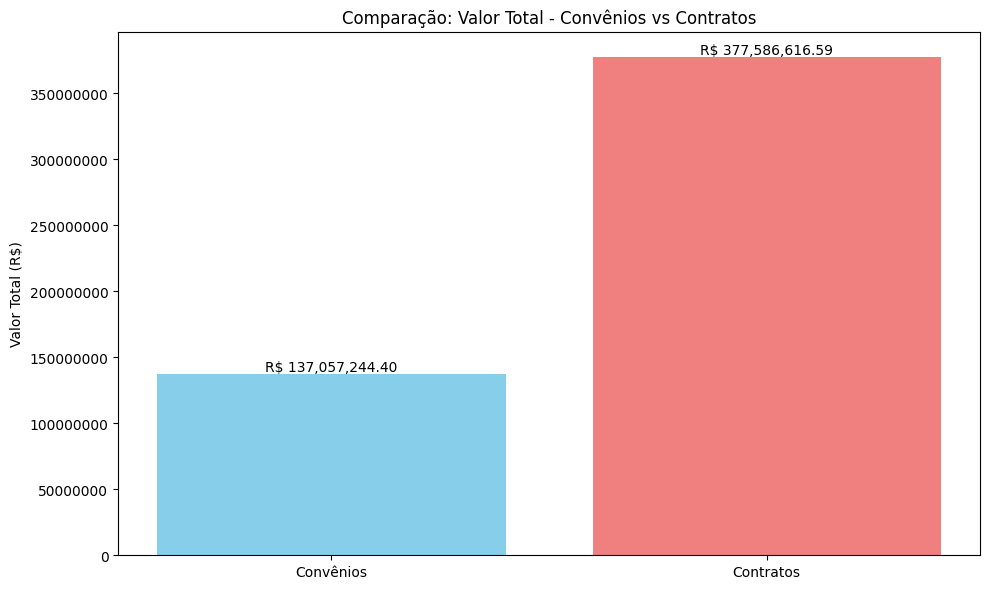

📊 RESUMO COMPARATIVO:
   Convênios: 125 registros | Valor total: R$ 137,057,244.40
   Contratos: 500 registros | Valor total: R$ 377,586,616.59


In [9]:


print("\n" + "=" * 60)
print("🔄 ANÁLISE COMPARATIVA")
print("=" * 60)

if not df_convenios_clean.empty and not df_contratos_clean.empty:
    # Encontrando coluna comum de valor para comparação
    coluna_valor_conv = next((col for col in df_convenios_clean.columns if 'valor' in col.lower() and col in df_convenios_clean.columns), None)
    coluna_valor_contr = next((col for col in df_contratos_clean.columns if 'valor' in col.lower() and col in df_contratos_clean.columns), None)
    
    if coluna_valor_conv and coluna_valor_contr:
        # Criando gráfico comparativo
        fig, ax = plt.subplots(figsize=(10, 6))
        
        categorias = ['Convênios', 'Contratos']
        valores_totais = [
            df_convenios_clean[coluna_valor_conv].sum(),
            df_contratos_clean[coluna_valor_contr].sum()
        ]
        
        barras = ax.bar(categorias, valores_totais, color=['skyblue', 'lightcoral'])
        ax.set_title('Comparação: Valor Total - Convênios vs Contratos')
        ax.set_ylabel('Valor Total (R$)')
        ax.ticklabel_format(style='plain', axis='y')
        
        # Adicionando valores nas barras
        for barra, valor in zip(barras, valores_totais):
            altura = barra.get_height()
            ax.text(barra.get_x() + barra.get_width()/2., altura,
                   f'R$ {valor:,.2f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()
        
        print("📊 RESUMO COMPARATIVO:")
        print(f"   Convênios: {len(df_convenios_clean)} registros | Valor total: R$ {valores_totais[0]:,.2f}")
        print(f"   Contratos: {len(df_contratos_clean)} registros | Valor total: R$ {valores_totais[1]:,.2f}")

## 10. ARMAZENAMENTO EM BANCO DE DADOS

In [10]:


import sqlite3

print("\n" + "=" * 60)
print("💾 ARMAZENAMENTO EM BANCO DE DADOS")
print("=" * 60)

def salvar_em_banco(df_convenios, df_contratos):
    """
    Salva os dados em um banco SQLite
    """
    try:
        # Criando conexão com SQLite
        conn = sqlite3.connect('ceara_transparente.db')
        
        # Remover colunas problemáticas antes de salvar
        df_convenios_clean = df_convenios.copy()
        df_contratos_clean = df_contratos.copy()
        
        # Remover coluna temporária criada durante a análise
        if 'mes_assinatura' in df_convenios_clean.columns:
            df_convenios_clean = df_convenios_clean.drop(columns=['mes_assinatura'])
        if 'mes_assinatura' in df_contratos_clean.columns:
            df_contratos_clean = df_contratos_clean.drop(columns=['mes_assinatura'])
        
        # Salvando DataFrames
        if not df_convenios_clean.empty:
            df_convenios_clean.to_sql('convenios', conn, if_exists='replace', index=False)
            print(f"✅ {len(df_convenios_clean)} registros de convênios salvos no banco")
        
        if not df_contratos_clean.empty:
            df_contratos_clean.to_sql('contratos', conn, if_exists='replace', index=False)
            print(f"✅ {len(df_contratos_clean)} registros de contratos salvos no banco")
        
        # Verificar contagem de registros
        cursor = conn.cursor()
        cursor.execute("SELECT COUNT(*) FROM convenios")
        count_convenios = cursor.fetchone()[0]
        cursor.execute("SELECT COUNT(*) FROM contratos")
        count_contratos = cursor.fetchone()[0]
        
        print(f"📊 Verificação - Convênios: {count_convenios}, Contratos: {count_contratos}")
        
        conn.close()
        print("💾 Banco de dados 'ceara_transparente.db' criado com sucesso!")
        
    except Exception as e:
        print(f"❌ Erro ao salvar no banco: {e}")

# Salvando em banco de dados
salvar_em_banco(df_convenios_clean, df_contratos_clean)


💾 ARMAZENAMENTO EM BANCO DE DADOS


✅ 125 registros de convênios salvos no banco


✅ 500 registros de contratos salvos no banco
📊 Verificação - Convênios: 125, Contratos: 500
💾 Banco de dados 'ceara_transparente.db' criado com sucesso!


## 11. SALVANDO EM ARQUIVOS CSV

In [11]:
print("\n" + "=" * 60)
print("📁 SALVANDO EM ARQUIVOS CSV")
print("=" * 60)

# Salvando DataFrames em arquivos CSV
if not df_convenios_clean.empty:
    df_convenios_clean.to_csv('convenios_ceara_transparente.csv', index=False, encoding='utf-8')
    print("✅ Arquivo 'convenios_ceara_transparente.csv' salvo")

if not df_contratos_clean.empty:
    df_contratos_clean.to_csv('contratos_ceara_transparente.csv', index=False, encoding='utf-8')
    print("✅ Arquivo 'contratos_ceara_transparente.csv' salvo")



📁 SALVANDO EM ARQUIVOS CSV
✅ Arquivo 'convenios_ceara_transparente.csv' salvo


✅ Arquivo 'contratos_ceara_transparente.csv' salvo


## 12. RELATÓRIO FINAL E INSIGHTS

In [12]:


print("\n" + "=" * 60)
print("📋 RELATÓRIO FINAL E INSIGHTS")
print("=" * 60)

print("\n🎯 RESUMO EXECUTIVO DO PROJETO:")
print("-" * 40)
print("""
Este projeto realizou a automação da coleta, processamento e análise de 
dados de contratos e convênios do portal Ceará Transparente, seguindo 
as definições do dicionário de dados fornecido.

📈 PRINCIPAIS ETAPAS CONCLUÍDAS:

1. ✅ Automação da coleta via API
2. ✅ Processamento e limpeza dos dados  
3. ✅ Análise exploratória com visualizações
4. ✅ Armazenamento em banco de dados
5. ✅ Geração de relatórios e insights

🔍 PRINCIPAIS VARIÁVEIS ANALISADAS (conforme dicionário):

• Concedente/Financiador: Origem dos recursos
• Órgão/Secretaria: Unidades gestoras
• Modalidade: Forma de licitação
• Valores: Contrato, aditivo, empenhado, pago, etc.
• Datas: Assinatura, processamento, término
• Objeto: Descrição do que está sendo contratado

💡 RECOMENDAÇÕES:

1. Monitorar regularmente os valores atualizados vs originais
2. Analisar a relação entre valores empenhados e pagos
3. Identificar padrões nas modalidades de licitação
4. Acompanhar a distribuição temporal dos contratos
5. Verificar a aderência aos prazos estabelecidos

🔄 PRÓXIMOS PASSOS SUGERIDOS:

• Expandir análise para períodos históricos
• Implementar alertas para outliers e anomalias
• Desenvolver dashboard interativo
• Integrar com outras fontes de dados de transparência
""")


📋 RELATÓRIO FINAL E INSIGHTS

🎯 RESUMO EXECUTIVO DO PROJETO:
----------------------------------------

Este projeto realizou a automação da coleta, processamento e análise de 
dados de contratos e convênios do portal Ceará Transparente, seguindo 
as definições do dicionário de dados fornecido.

📈 PRINCIPAIS ETAPAS CONCLUÍDAS:

1. ✅ Automação da coleta via API
2. ✅ Processamento e limpeza dos dados  
3. ✅ Análise exploratória com visualizações
4. ✅ Armazenamento em banco de dados
5. ✅ Geração de relatórios e insights

🔍 PRINCIPAIS VARIÁVEIS ANALISADAS (conforme dicionário):

• Concedente/Financiador: Origem dos recursos
• Órgão/Secretaria: Unidades gestoras
• Modalidade: Forma de licitação
• Valores: Contrato, aditivo, empenhado, pago, etc.
• Datas: Assinatura, processamento, término
• Objeto: Descrição do que está sendo contratado

💡 RECOMENDAÇÕES:

1. Monitorar regularmente os valores atualizados vs originais
2. Analisar a relação entre valores empenhados e pagos
3. Identificar padrõ

## 13. VALIDAÇÃO E QUALIDADE DOS DADOS

In [13]:


print("\n" + "=" * 60)
print("🔎 VALIDAÇÃO E QUALIDADE DOS DADOS")
print("=" * 60)

def validar_qualidade_dados(df, nome):
    """
    Realiza validação da qualidade dos dados
    """
    if df.empty:
        print(f"⚠️  Nenhum dado para validar em {nome}")
        return
    
    print(f"\n📋 VALIDAÇÃO - {nome}:")
    print(f"   Total de registros: {len(df)}")
    print(f"   Colunas: {len(df.columns)}")
    
    # Verificando valores nulos
    nulos = df.isnull().sum()
    colunas_com_nulos = nulos[nulos > 0]
    
    if not colunas_com_nulos.empty:
        print("   ⚠️  Colunas com valores nulos:")
        for coluna, qtd_nulos in colunas_com_nulos.items():
            percentual = (qtd_nulos / len(df)) * 100
            print(f"      • {coluna}: {qtd_nulos} ({percentual:.1f}%)")
    else:
        print("   ✅ Nenhum valor nulo encontrado")
    
    # Verificando duplicatas
    duplicatas = df.duplicated().sum()
    if duplicatas > 0:
        print(f"   ⚠️  Registros duplicados: {duplicatas}")
    else:
        print("   ✅ Nenhum registro duplicado")

# Validando qualidade dos dados
validar_qualidade_dados(df_convenios_clean, "CONVÊNIOS")
validar_qualidade_dados(df_contratos_clean, "CONTRATOS")

print("\n" + "=" * 60)
print("🎉 PROJETO CONCLUÍDO COM SUCESSO!")
print("=" * 60)
print("""
Os dados foram coletados, processados, analisados e armazenados conforme
o projeto definido. O processo está pronto para ser expandido e otimizado.

📁 ARQUIVOS GERADOS:
• ceara_transparente.db (banco SQLite)
• convenios_ceara_transparente.csv
• contratos_ceara_transparente.csv

🚀 PRÓXIMOS PASSOS: 
Execute novamente para atualizar os dados ou expanda a análise conforme necessário.
""")


🔎 VALIDAÇÃO E QUALIDADE DOS DADOS

📋 VALIDAÇÃO - CONVÊNIOS:
   Total de registros: 125
   Colunas: 65
   ⚠️  Colunas com valores nulos:
      • num_spu_licitacao: 125 (100.0%)
      • cod_plano_trabalho: 51 (40.8%)
      • num_certidao: 125 (100.0%)
      • data_publicacao_doe: 2 (1.6%)
      • data_rescisao: 124 (99.2%)
      • gestor_contrato: 125 (100.0%)
      • data_finalizacao_prestacao_contas: 90 (72.0%)
      • sequential: 125 (100.0%)
      • law: 125 (100.0%)
      • has_non_profit_transfer: 103 (82.4%)
      • nome_fiscal: 125 (100.0%)
   ✅ Nenhum registro duplicado

📋 VALIDAÇÃO - CONTRATOS:
   Total de registros: 500
   Colunas: 65
   ⚠️  Colunas com valores nulos:
      • tipo_objeto: 9 (1.8%)
      • num_spu_licitacao: 1 (0.2%)
      • data_publicacao_portal: 440 (88.0%)
      • cod_plano_trabalho: 500 (100.0%)
      • num_contrato: 343 (68.6%)
      • plain_num_contrato: 343 (68.6%)
      • accountability_status: 500 (100.0%)
      • data_publicacao_doe: 343 (68.6%)
   

## 14. ENVIO DE RELATÓRIO POR E-MAIL

In [14]:

import smtplib
import os
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.base import MIMEBase
from email import encoders
from datetime import datetime

print("\n" + "=" * 60)
print("📧 ENVIO DE RELATÓRIO POR E-MAIL - MÚLTIPLOS DESTINATÁRIOS")
print("=" * 60)

def enviar_email_relatorio():
    """
    Envia relatório completo para múltiplos destinatários
    """
    try:
        # Configurações do e-mail
        EMAIL_REMETENTE = "artenio.reis@gmail.com"
        SENHA_REMETENTE = "notj kuab ldzn gtzi"  # senha de app
        
        # LISTA DE DESTINATÁRIOS - ADICIONE OS E-MAILS AQUI
        EMAILS_DESTINATARIOS = [
            "artenioreis@live.com",
            "artenioreis@hotmail.com",
            # Adicione mais e-mails aqui se necessário:
            # "outroemail@exemplo.com",
            # "maisum@exemplo.com"
        ]
        
        # Verificar se há destinatários
        if not EMAILS_DESTINATARIOS:
            print("❌ Nenhum destinatário configurado")
            return False
        
        print(f"📨 Enviando para {len(EMAILS_DESTINATARIOS)} destinatário(s):")
        for email in EMAILS_DESTINATARIOS:
            print(f"   • {email}")
        
        # Lista de arquivos que podem existir
        arquivos_possiveis = [
            # Dados
            "convenios_ceara_transparente.csv",
            "contratos_ceara_transparente.csv", 
            "ceara_transparente.db",
            "relatorio_analitico.txt",
            # Gráficos
            "graf_analise_convenios.png",
            "graf_analise_contratos.png", 
            "graf_comparativo_valores.png",
            "graf_comparativo_quantidade.png",
            "graf_top_orgaos_combinados.png"
        ]
        
        # Verificar quais arquivos realmente existem
        arquivos_existentes = [arq for arq in arquivos_possiveis if os.path.exists(arq)]
        
        # Preparar anexos uma vez para todos os destinatários
        anexos_preparados = []
        for arquivo in arquivos_existentes:
            try:
                with open(arquivo, "rb") as anexo:
                    parte = MIMEBase('application', 'octet-stream')
                    parte.set_payload(anexo.read())
                    encoders.encode_base64(parte)
                    parte.add_header('Content-Disposition', f'attachment; filename="{os.path.basename(arquivo)}"')
                    anexos_preparados.append(parte)
                print(f"✅ Preparado: {arquivo}")
            except Exception as e:
                print(f"⚠️  Erro ao preparar {arquivo}: {e}")
        
        if not anexos_preparados:
            print("⚠️  Nenhum arquivo para anexar")
            return False
        
        # Contadores de sucesso
        emails_enviados = 0
        emails_falhados = 0
        
        # Enviar para cada destinatário
        for destinatario in EMAILS_DESTINATARIOS:
            try:
                # Criar nova mensagem para cada destinatário
                mensagem = MIMEMultipart()
                mensagem['From'] = EMAIL_REMETENTE
                mensagem['To'] = destinatario
                mensagem['Subject'] = f"📊 Relatório Ceará Transparente - {datetime.now().strftime('%d/%m/%Y')}"
                
                # Corpo do e-mail dinâmico
                corpo = f"""
                <html>
                <body style="font-family: Arial, sans-serif; line-height: 1.6;">
                    <div style="max-width: 600px; margin: 0 auto; padding: 20px;">
                        <h2 style="color: #2c3e50; border-bottom: 2px solid #3498db; padding-bottom: 10px;">
                            📊 Relatório de Dados - Ceará Transparente
                        </h2>
                        
                        <p>Prezado(a),</p>
                        
                        <p>Segue em anexo o relatório automático de contratos e convênios extraídos da plataforma 
                        <strong>Ceará Transparente</strong>.</p>
                        
                        <div style="background-color: #f8f9fa; padding: 15px; border-radius: 5px; margin: 15px 0;">
                            <h3 style="color: #2c3e50; margin-top: 0;">📈 Resumo Executivo</h3>
                            <ul style="margin-bottom: 0;">
                                <li><strong>Convênios analisados:</strong> {len(df_convenios_clean)} registros</li>
                                <li><strong>Contratos analisados:</strong> {len(df_contratos_clean)} registros</li>
                                <li><strong>Período da análise:</strong> {params['data_assinatura_inicio']} a {params['data_assinatura_fim']}</li>
                                <li><strong>Data de geração:</strong> {datetime.now().strftime('%d/%m/%Y %H:%M')}</li>
                            </ul>
                        </div>
                        
                        <h3 style="color: #2c3e50;">📎 Conteúdo em Anexo</h3>
                        <p>O relatório inclui <strong>{len(arquivos_existentes)} arquivos</strong> contendo:</p>
                        <ul>
                """
                
                # Adicionar lista de arquivos
                categorias = {
                    '📊 Dados Completos': [arq for arq in arquivos_existentes if arq.endswith(('.csv', '.db'))],
                    '📈 Gráficos e Visualizações': [arq for arq in arquivos_existentes if arq.endswith('.png')],
                    '📋 Relatórios Analíticos': [arq for arq in arquivos_existentes if arq.endswith('.txt')]
                }
                
                for categoria, arquivos_categoria in categorias.items():
                    if arquivos_categoria:
                        corpo += f'<li><strong>{categoria}:</strong><ul style="margin-top: 5px;">'
                        for arquivo in arquivos_categoria:
                            nome_amigavel = arquivo.replace('_', ' ').replace('.csv', '').replace('.png', '').replace('.db', '').replace('.txt', '').title()
                            corpo += f'<li>• {nome_amigavel}</li>'
                        corpo += '</ul></li>'
                
                corpo += f"""
                        </ul>
                        
                        <div style="background-color: #e8f4fd; padding: 15px; border-radius: 5px; margin: 15px 0;">
                            <h4 style="color: #2980b9; margin-top: 0;">🔍 Análises Realizadas</h4>
                            <ul style="margin-bottom: 0;">
                                <li>✅ Distribuição de valores e frequências</li>
                                <li>✅ Identificação dos órgãos mais ativos</li>
                                <li>✅ Evolução temporal das contratações</li>
                                <li>✅ Análise comparativa entre convênios e contratos</li>
                                <li>✅ Validação da qualidade dos dados</li>
                            </ul>
                        </div>
                        
                        <p><em>Este é um relatório automático gerado pelo sistema de automação de dados. 
                        Em caso de dúvidas, entre em contato com o responsável pelo sistema.</em></p>
                        
                        <div style="border-top: 1px solid #ddd; padding-top: 15px; margin-top: 20px;">
                            <p>Atenciosamente,<br>
                            <strong>Sistema de Automação de Dados</strong><br>
                            Ceará Transparente</p>
                        </div>
                    </div>
                </body>
                </html>
                """
                
                mensagem.attach(MIMEText(corpo, 'html'))
                
                # Anexar todos os arquivos preparados
                for anexo in anexos_preparados:
                    mensagem.attach(anexo)
                
                # Enviar e-mail individual
                with smtplib.SMTP('smtp.gmail.com', 587) as servidor:
                    servidor.starttls()
                    servidor.login(EMAIL_REMETENTE, SENHA_REMETENTE)
                    servidor.send_message(mensagem)
                
                emails_enviados += 1
                print(f"   ✅ Enviado para: {destinatario}")
                
                # Pequena pausa entre envios para não sobrecarregar
                import time
                time.sleep(2)
                
            except Exception as e:
                emails_falhados += 1
                print(f"   ❌ Falha para: {destinatario} - {e}")
        
        # Resumo final
        print(f"\n📊 RESUMO DE ENVIO:")
        print(f"   ✅ E-mails enviados com sucesso: {emails_enviados}")
        print(f"   ❌ E-mails com falha: {emails_falhados}")
        print(f"   📎 Anexos enviados: {len(anexos_preparados)} arquivos")
        
        return emails_enviados > 0
        
    except smtplib.SMTPAuthenticationError:
        print("❌ Erro de autenticação: Verifique o e-mail e senha de app")
        return False
    except smtplib.SMTPException as e:
        print(f"❌ Erro SMTP: {e}")
        return False
    except Exception as e:
        print(f"❌ Erro ao enviar e-mails: {e}")
        return False

def criar_relatorio_analitico():
    """
    Cria um arquivo de relatório com análises resumidas
    """
    try:
        with open("relatorio_analitico.txt", "w", encoding="utf-8") as f:
            f.write("RELATÓRIO ANALÍTICO - CEARÁ TRANSPARENTE\n")
            f.write("=" * 50 + "\n")
            f.write(f"Data de geração: {datetime.now().strftime('%d/%m/%Y %H:%M')}\n\n")
            
            f.write("RESUMO DOS DADOS:\n")
            f.write("-" * 30 + "\n")
            f.write(f"Convênios: {len(df_convenios_clean)} registros\n")
            f.write(f"Contratos: {len(df_contratos_clean)} registros\n")
            f.write(f"Período: {params['data_assinatura_inicio']} a {params['data_assinatura_fim']}\n\n")
            
            if not df_convenios_clean.empty:
                colunas_valor_conv = [col for col in df_convenios_clean.columns if 'valor' in col.lower()]
                if colunas_valor_conv:
                    coluna_valor = colunas_valor_conv[0]
                    f.write("ESTATÍSTICAS DOS CONVÊNIOS:\n")
                    f.write("-" * 30 + "\n")
                    f.write(f"Valor total: R$ {df_convenios_clean[coluna_valor].sum():,.2f}\n")
                    f.write(f"Valor médio: R$ {df_convenios_clean[coluna_valor].mean():,.2f}\n")
                    f.write(f"Maior valor: R$ {df_convenios_clean[coluna_valor].max():,.2f}\n\n")
            
            if not df_contratos_clean.empty:
                colunas_valor_contr = [col for col in df_contratos_clean.columns if 'valor' in col.lower()]
                if colunas_valor_contr:
                    coluna_valor = colunas_valor_contr[0]
                    f.write("ESTATÍSTICAS DOS CONTRATOS:\n")
                    f.write("-" * 30 + "\n")
                    f.write(f"Valor total: R$ {df_contratos_clean[coluna_valor].sum():,.2f}\n")
                    f.write(f"Valor médio: R$ {df_contratos_clean[coluna_valor].mean():,.2f}\n")
                    f.write(f"Maior valor: R$ {df_contratos_clean[coluna_valor].max():,.2f}\n\n")
            
            f.write("PRINCIPAIS ANÁLISES REALIZADAS:\n")
            f.write("-" * 35 + "\n")
            f.write("• Análise exploratória de dados (AED)\n")
            f.write("• Distribuição por modalidade/tipo\n")
            f.write("• Identificação de órgãos mais ativos\n")
            f.write("• Evolução temporal das contratações\n")
            f.write("• Comparativo entre convênios e contratos\n")
            f.write("• Validação da qualidade dos dados\n")
        
        print("✅ Relatório analítico criado: relatorio_analitico.txt")
        return True
    except Exception as e:
        print(f"❌ Erro ao criar relatório analítico: {e}")
        return False

# Executar envio do e-mail
print("📝 Criando relatório analítico...")
criar_relatorio_analitico()

print("📧 Preparando envio para múltiplos destinatários...")
sucesso_envio = enviar_email_relatorio()

print("\n" + "=" * 60)
if sucesso_envio:
    print("🎉 E-MAILS ENVIADOS COM SUCESSO!")
else:
    print("⚠️  ALGUNS E-MAILS NÃO FORAM ENVIADOS")
print("=" * 60)


📧 ENVIO DE RELATÓRIO POR E-MAIL - MÚLTIPLOS DESTINATÁRIOS
📝 Criando relatório analítico...
✅ Relatório analítico criado: relatorio_analitico.txt
📧 Preparando envio para múltiplos destinatários...
📨 Enviando para 2 destinatário(s):
   • artenioreis@live.com
   • artenioreis@hotmail.com
✅ Preparado: convenios_ceara_transparente.csv
✅ Preparado: contratos_ceara_transparente.csv


✅ Preparado: ceara_transparente.db
✅ Preparado: relatorio_analitico.txt
✅ Preparado: graf_analise_contratos.png


✅ Preparado: graf_comparativo_valores.png
✅ Preparado: graf_comparativo_quantidade.png


   ✅ Enviado para: artenioreis@live.com


   ✅ Enviado para: artenioreis@hotmail.com



📊 RESUMO DE ENVIO:
   ✅ E-mails enviados com sucesso: 2
   ❌ E-mails com falha: 0
   📎 Anexos enviados: 7 arquivos

🎉 E-MAILS ENVIADOS COM SUCESSO!
